In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipy_io
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.optimize import fmin_cg

In [3]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes, labels=False):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if labels:
                sub = str(m+1)
                if n == 0:
                    ax.text(n*h_spacing + left, layer_top - m*v_spacing, 
                            r"$x_{:d}$".format(m+1), 
                        ha='center', va='center', zorder=5)
                else:
                    sup = '('+ str(n+1) +')'                    
                    ax.text(n*h_spacing + left, layer_top - m*v_spacing, 
                            r"$a^{:d}_{:d}$".format(n+1, m+1), 
                        ha='center', va='center', zorder=5)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in xrange(layer_size_a):
            for o in xrange(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Implementing a Neural Network
The assignments for the Coursera Machine Learning course require you to implement a neural network using the feedfoward and backpropagation algorithms.  I didn't want to submit the assignments in matlab/octave, so I decided just to write them up in Python and post as a blog post.

## The data
The dataset was provided as part of the assignment, essentially it is a number of greyscale images of handwritten digits (0-9), along with the correct classification for that image.  The images look like this: 

In [24]:
pix_file = '../assignments/machine-learning-ex4/ex4/ex4data1.mat'
mat_in = scipy_io.loadmat(pix_file)
X_in = mat_in['X']
y = np.squeeze(mat_in['y'])
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_in, y, test_size=0.2)


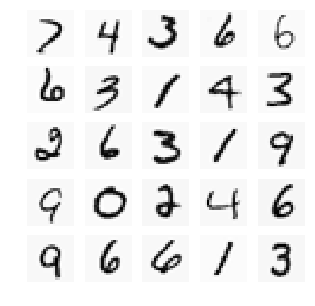

In [25]:
fig,ax = plt.subplots(5,5, figsize=(5,5))
axs = iter(np.ravel(ax))
for i in np.random.randint(0, 3000, 25):
    ax = next(axs)
    ax.imshow(X_train[i,:].reshape(20,20).T, cmap='Greys');
    ax.set_axis_off();

## The neural network
The network I am using for this example consists of 3 layers - an input layer, an output layer, and one hidden layer.  The input layer consists of 400 input nodes (each pixel in an image, and there is actually 401 inputs when the bias, $x_0=1$, term is included).  I'm using 25 nodes (or neurons) in the hidden layer (this also gets a bias term added, $a_0^{(2)}=1$), and the output layer consists of 10 nodes - one for each of the classes.

### Feed-forward
The feed-forward calculation takes the inputs values, and applies the activation function (in this case the sigmoid) using the provided weights ($\Theta$).  These values are then "fed-forward", used as the inputs to the next activation layer.  If we have a simple neural net, consisting of 3 layers with sizes 3, 3, 1 such as this: 

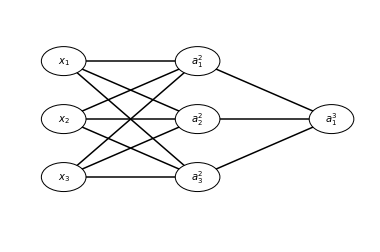

In [26]:
fig, ax = plt.subplots(1,1)
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [3, 3, 1], labels=True)

Then we can calculate the values:

$$
a^2_1 = g(\Theta^1_{10}x_0 + \Theta^1_{11}x_1 + \Theta^1_{12}x_2 + \Theta^1_{13}x_3)
$$
$$
a^2_2 = g(\Theta^1_{20}x_0 + \Theta^1_{21}x_1 + \Theta^1_{22}x_2 + \Theta^1_{23}x_3)
$$
$$
a^2_3 = g(\Theta^1_{30}x_0 + \Theta^1_{31}x_1 + \Theta^1_{32}x_2 + \Theta^1_{33}x_3)
$$
and,
$$
a^3_1 = h_\Theta(x) = g(\Theta^2_{10}a^2_0 + \Theta^2_{11}a^2_1 + \Theta^2_{12}a^2_2 + \Theta^2_{13}a^2_3)
$$

Where $\Theta^l$ for $l=1,2$ are the weights mapping from layer $l$ to $l+1$ and $g(z)$ is the activation function (the sigmoid function).  This can be vectorised fairly easily. Generally, if $a^{(l)} = [a^{(l)}_0, a^{(l)}_1,..., a_{s_j}^{(l)}]$ and $z^{(l)} = [z^{(l)}_1,..., z_{s_l}^{(l)}]$, $a^{(l)} = g(z^{(l)})$, where $z^{(l)} = \Theta^{(l-1)}a^{(l-1)}$.  This is implemented in the `feedforward()` function below.

In [27]:
# Some helper functions
def add_bias_term(a):
    '''Inserts a 1 to the firt column of the array '''
    m,n = a.shape
    b = np.ones([m, n+1])
    b[:,1:] = a
    return b

def x_to_theta(x, s_1, s_2, s_3):
    '''Takes the vector of weights and unravels to the required array shapes'''
    Theta1 = x[:s_2*(s_1+1)].reshape([s_2, s_1+1])
    Theta2 = x[s_2*(s_1+1):].reshape([s_3, s_2+1])
    return Theta1, Theta2

def sigmoid(z):
    return 1./(1. + np.exp(-1.*z))

def sigmoidGradient(z):
    return sigmoid(z) * (1. - sigmoid(z))

In [28]:
def feedforward(X, n_layers, theta=None):
    '''performs the feedfoward calculation in the neural net using the sigmoid activation function
    inputs:
        X: input variables
        n_layers: total number of layers in the neural network
        theta: list of length n_layers-1 containing the weights for each neuron for each 
                activation layer (1,..., n_layers)
    returns:
        a_out: list of length n_layers-1 containg the computed activations for each layer (1,...,n_layers)
    '''
    
    a_outs = []
    
    #check for theta
    if theta is not None:
        # check theta lengths
        if len(theta) == n_layers-1:
            #calculate the activations for each of the layers
            for j in range(n_layers-1):
                # add the bias terms
                if j==0:
                    # activation is peformed on the input X values
                    a = add_bias_term(X)                  
                else:
                    # activation is performed on the previous layers activation
                    a = add_bias_term(a_out)
                
                # get the number of neurons for each layer 
                theta_j = theta[j]              
                # calculate the activation
                a_out = sigmoid(np.dot(a, theta_j.T)) 
                a_outs.append(a_out)
                
            return a_outs
        else:
            print 'theta list is of wrong dimension'
            return None
    else:
        print 'need to provide thetas'
        return None

### Back-propagation
In order for the neural net to "learn" the optimal weights (or parameters, $\Theta$) for the classification, we need to minimise the cost function over $\Theta$.  To do this we need the cost function, $J(\Theta)$, and its gradient, $\frac{\partial J(\Theta)}{\partial \Theta_{ij}}$ 
#### Cost function

The cost function we're using for this neural network is similar to that for the logistic regression, with the addition of a sum over the number of classes, $k$.
$$
J(\theta) = \frac{-1}{m}[\sum^m_{i=1} \sum^K_{k=1} [y_k^{(i)} log(h_{\theta}(x^{(i)})_k) - (1-y_k^{(i)}) log(1 - h_{\theta}(x^{(i)})_k)] + \frac{\lambda}{2m} \sum^{L-1}_{l=1} \sum^{S_1}_{i=1} \sum^{S_{1+1}}_{j=1}(\Theta_{ji}^l)^2
$$

This is implemented in the `nn_costfunction()` function below.

In [29]:
# functions to use with scipy's fmin_cg
def nn_costfunction(x, *args):
    '''Calculates the cost function value for the neural net
        inputs: 
            x: vector containing weights
            args: tuple containing:
                    y: feature vector
                    X_f: input variables
                    n_layers: number of layers in the neural net
                    k: number of classes
                    s_1: number of variables for each input
                    s_2: number of neurons in layer 2
                    s_3: number of neurons in layer 3
                    lamb: lambda weigting for regularisation
        return:
            J_theta: value of the cost function
            
    TODO: make the code insensitive to the number of layers
    '''
    y, X_f, n_layers, k, s_1, s_2, s_3, lamb = args 
    
    # create an [m, k] y (feature) array, where the column index 
    # corresponding to the class of that row is set to 1
    m = y.size
    y_exp = np.zeros([m, k])
    y_exp[range(m),y-1] = 1
    
    # convert the input x vector to the theta arrays
    Theta1, Theta2 = x_to_theta(x, s_1, s_2, s_3)
    
    # compute the activations using the feedfoward function
    a_outs = feedforward(X_f, n_layers=n_layers, theta=[Theta1, Theta2])
    
    # the final classification is set to the last entry in a_outs
    h_theta_x = a_outs[n_layers - 2]
    h_theta_x[h_theta_x==1] = 0.9999 #just in case.  If these are excatly 1 the log fails     
    
    # calclute the cost function
    J_theta = np.sum(-1.* y_exp * np.log(h_theta_x) - (1. - y_exp) * np.log(1. - h_theta_x))/float(m)

    #include regularization
    if lamb is not None:
        J_theta = J_theta + (lamb/(2*m)) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))   
   
    return J_theta
    


####  Gradient
The gradient is calculated via the method of back-propagation.  The basic idea behind this approach is that the error between the actual values and the predicted values (as determined by the cost function) is propagated back through the neural network, starting from the final layer.  The weight connecting each node (or neuron) is assigned a portion of the error, based upon the gradient of the cost function.  

Starting at the final layer ($l=L=3$ in this case), we can write (via the chain-rule):

$$
\frac{\partial J(\Theta)}{\partial \Theta^{(L-1)}} = 
\frac{\partial J(\Theta)}{\partial a^{(L)}} 
\frac{\partial a^{(L)}}{\partial z^{(L)}} 
\frac{\partial z^{(L)}}{\partial \Theta^{(L-1)}}
$$

and for the second layer (the hidden layer, $l=2$):


$$
\frac{\partial J(\Theta)}{\partial \Theta^{(L-2)}} = 
\frac{\partial J(\Theta)}{\partial a^{(L)}} 
\frac{\partial a^{(L)}}{\partial z^{(L)}} 
\frac{\partial z^{(L)}}{\partial a^{(L-1)}}
\frac{\partial a^{(L-1)}}{\partial z^{(L-1)}}
\frac{\partial z^{(L-1)}}{\partial \Theta^{(L-2)}}
$$

Generally, 

$$
\frac{\partial z^{(l)}}{\partial \Theta^{(l-1)}} = \frac{\partial (\Theta^{(l-1)}a^{(l-1)})}{\partial \Theta^{(l-1)}} = a^{(l-1)}
$$

and we set

$$
\frac{\partial J(\Theta)}{\partial a^{(L)}} 
\frac{\partial a^{(L)}}{\partial z^{(L)}}  = \delta^{(L)}
$$

and then
$$
\delta^{(L)} 
\frac{\partial z^{(L)}}{\partial a^{(L-1)}}
\frac{\partial a^{(L-1)}}{\partial z^{(L-1)}} = \delta^{(L-1)}
$$

Given that $a = g(z)$ and, $\frac{\partial a}{\partial z} = a(1-a)$, $\delta^{(L)}$ reduces (via some calculus and substitutions) to:
$$
\delta^{(L)} = a^{(L)} - y        
$$

and, as 

$$
\frac{\partial z^{(l)}}{\partial a^{(l-1)}} = \frac{\partial (\Theta^{(l-1)}a^{(l-1)})}{\partial a^{(l-1)}} = \Theta^{(l-1)}
$$

$\delta^{(L-1)}$ reduces to:
$$
\delta^{(L-1)} = \delta^{(L)}\Theta^{(L-1)} a^{(L-1)}(1-a^{(L-1)})
$$

So, putting it all together we get (for $L=3$),
$$
\frac{\partial J(\Theta)}{\partial \Theta^{(2)}} = \delta^{(3)}a^{(2)}
$$
and,
$$
\frac{\partial J(\Theta)}{\partial \Theta^{(1)}} = \delta^{(2)}a^{(1)}
$$

This is implemented in `nn_grad()` below.  This has not been optimised in anyway (pretty sure it can be vectorized to remove the loop), but it works and gives a good idea of what the algorithm is doing.

In [30]:
def nn_grad(x, *args):
    '''
    Performs the back-propagation algorithm in order to calculate the partial differntial of the
    cost function.
        inputs: 
            x: vector containing weights
            args: tuple containing:
                    y: feature vector
                    X_f: input variables
                    n_layers: number of layers in the neural net
                    k: number of classes
                    s_1: number of variables for each input
                    s_2: number of neurons in layer 2
                    s_3: number of neurons in layer 3
                    lamb: lambda weigting for regularisation
        return:
            J_theta: value of the cost function
            
    TODO: make the code insensitive to the number of layers
    '''
    
    y, X_f, n_layers, k, s_1, s_2, s_3, lamb = args 
    
    # create an [m, k] y (feature) array, where the column index 
    # corresponding to the class of that row is set to 1
    m = y.size
    y_exp = np.zeros([m, k])
    y_exp[range(m),y-1] = 1
    
    # convert the input x vector to the theta arrays
    Theta1, Theta2 = x_to_theta(x, s_1, s_2, s_3)
    
    # initialise the Del arrays (used to store the accumulated cost function gradients)
    Del_1 = np.zeros([s_2, s_1+1])
    Del_2 = np.zeros([s_3, s_2+1])
    
    # loop over the input variables
    for t in range(m):
        
        # this just makes the input variable a [1,s_1] vector instead of a [s_1,]
        x_in = np.expand_dims(X_f[t,:], axis=0)
        
        # compute the activations
        a_outs = feedforward(x_in, n_layers=n_layers, theta=[Theta1, Theta2])
        a_3 = a_outs[1]
        a_2 = add_bias_term(a_outs[0])
        x_in = add_bias_term(x_in)
        
        # compute the "error" between the predicted values and actual values
        delta_3 = a_3 - y_exp[t,:]
        
        # apportion the error due to each of the neurons in layer 2 
        delta_2 = np.dot(delta_3, Theta2) * a_2 * (1. - a_2)
        
        # calculate and accumulate the gradients
        Del_2 += np.dot(delta_3.T, a_2)
        Del_1 += np.dot(delta_2[:,1:].T, x_in)
    
    Del_1 = Del_1/m
    Del_2 = Del_2/m
    
    # apply regularisation
    if lamb is not None:
        Del_1[:,1:] =  Del_1[:,1:] + lamb/(2. * m) * Theta1[:,1:]
        Del_2[:,1:] =  Del_2[:,1:] + lamb/(2. * m) * Theta2[:,1:]
     
    grad_out = np.zeros(Del_1.size + Del_2.size)
    grad_out[:s_2*(s_1+1)] = Del_1.ravel()
    grad_out[s_2*(s_1+1):] = Del_2.ravel()
    
    return grad_out

### Running the neural network
The neural network is initialised using randomly assigned arrays for `initTheta1` and `initTheta2`, and the scipy routine `fmin_cg` is used to iterate through and minimise the cost function. 

In [45]:
#number of classes
k = 10

# input sizes
s_1 = 400
s_2 = 25
s_3 = 10

# set regularization
lamb = 0.1

# number of layers
n_layers = 3

#arguments that get used in the cost and grad functions 
args = (y_train, X_train, n_layers, k, s_1, s_2, s_3, lamb)

# initialise the Theta arrays with some random values
initE = 0.3
# np.random.seed(0)
initTheta1 = np.random.rand(s_2, s_1+1) * 2 * initE - initE
# np.random.seed(0)
initTheta2 = np.random.rand(s_3, s_2+1) * 2 * initE - initE

#put the theta arrays into a vector
x = np.zeros(initTheta1.size + initTheta2.size)
x[:initTheta1.size] = initTheta1.ravel()
x[initTheta1.size:] = initTheta2.ravel()

# print nn_costfunction(x, *args)
# print nn_grad(x, *args)

# run the optimisation code
theta_out = fmin_cg(nn_costfunction, x, fprime=nn_grad, args=args, maxiter=400)

         Current function value: 0.079758
         Iterations: 400
         Function evaluations: 1349
         Gradient evaluations: 1349


The minimisation function returns the optimal $\Theta$ arrays, we can then take those values and feed them through the neural network to get $h(\Theta)_x$, our predicted classification. 

In [46]:
Theta1, Theta2 = x_to_theta(theta_out, s_1, s_2, s_3)
a_outs = feedforward(X_test, n_layers=n_layers, theta=[Theta1, Theta2])
h_theta_x = a_outs[1]
#find the most-likely class (maximum value in row), adds 1 because index 0 is class 1, not class 0.
y_pred = np.argmax(h_theta_x, axis=1) + 1 

In [47]:
print 'Agreement rate {0:2.2f}%'.format( 100.0*np.sum(y_test==y_pred)/float(y_test.size))
print 'Confusion matrix:'
confusion_matrix(y_test, y_pred)

Agreement rate 92.80%
Confusion matrix:


array([[101,   1,   0,   0,   3,   0,   0,   2,   0,   0],
       [  1,  98,   0,   0,   0,   2,   1,   3,   1,   0],
       [  0,   0,  79,   1,   1,   0,   0,   2,   0,   0],
       [  0,   0,   0,  99,   0,   4,   0,   0,   2,   0],
       [  0,   0,   3,   0,  92,   1,   0,   1,   1,   0],
       [  1,   1,   0,   0,   0,  91,   0,   1,   0,   1],
       [  1,   2,   0,   0,   0,   1,  87,   1,   4,   1],
       [  0,   1,   0,   0,   2,   1,   3,  95,   5,   1],
       [  1,   0,   1,   6,   0,   0,   3,   2,  92,   1],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,  94]])

This shows we get a ~93% agreement between the predicted and actual classifications.  Its OK agreement, it might be possible to improve the agreement by increasing the number of neurons, layers, playing with the regularisation value, and running it for more iterations.  But it has been interesting building the neural network, and has given me a goodinsight into the mechanics of a basic neural network.     